In [253]:
#  Task2: Comparison of normalization methods for classification on Image dataset 2
# • Model: MLFFNN with 2 hidden layers and tanh activation function
# • Lossfunction: Cross-entropy
# • Mode of learning: Mini-batch mode
# • Stopping criterion: Change in average error below a threshold
# • Weight update rule: AdaM
# • Normalization method: (1) No normalization, (2) Batch normalization with post-activation normalization 
# • Use the same value of learning rate parameter
# • Use the same initial random values of weights
# • For each normalization method, report should include the following: (a) Plot of
# average error on training data vs Epoch,(b) Confusion matricesfortraining data and
# test data
# • Compare number of epochs taken for convergence for normalization methods

# Dataset:
# it is in ./task2 {folder}
# the {folder} has 6 files
# test_data.csv
# test_label.csv
# train_data.csv
# train_label.csv
# val_data.csv
# val_label.csv

# Train data shape -> (2000, 36)
# Train label shape -> (2000, 1)
# Test data shape -> (500, 36)
# Test label shape -> (500, 1)
# Val data shape -> (500, 36)
# Val label shape -> (500, 1)

# You can use Pytorch as well. No need to implement neural network from scratch.
# You can use any library for plotting the graphs.


In [254]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")


In [255]:
folder = ""

def seed_all(seed=59+87+122+143):
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


In [256]:
class DataLoader:
    def __init__(self, train_data_path, train_label_path, val_data_path, val_label_path, test_data_path, test_label_path):
        self.train_data, self.train_labels = self.load_data(train_data_path, train_label_path)
        self.val_data, self.val_labels = self.load_data(val_data_path, val_label_path)
        self.test_data, self.test_labels = self.load_data(test_data_path, test_label_path)

    def load_data(self, data_path, label_path):
        data = pd.read_csv(data_path, header=None).values.astype(np.float32)
        labels = pd.read_csv(label_path, header=None).values.flatten().astype(np.int64)
        return data, labels

    def standardize_data(self):
        scaler = StandardScaler()
        scaler.fit(self.train_data)
        self.train_data = scaler.transform(self.train_data)
        self.val_data = scaler.transform(self.val_data)
        self.test_data = scaler.transform(self.test_data)


In [257]:
class MLFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, batch_norm):
        super(MLFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation = nn.Tanh()
        self.output_activation = nn.Softmax(dim=1)
        self.batch_norm = batch_norm
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x) if self.batch_norm == "pre" else x
        x = self.activation(x)
        x = self.bn1(x) if self.batch_norm == "post" else x
        x = self.fc2(x)
        x = self.bn2(x) if self.batch_norm == "pre" else x
        x = self.activation(x)
        x = self.bn2(x) if self.batch_norm == "post" else x
        x = self.fc3(x)
        x = self.output_activation(x)
        return x


In [258]:
class NeuralNetworkClassifier:
    def __init__(self, model, criterion, optimizer, epochs, threshold, batch_size):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.threshold = threshold
        self.batch_size = batch_size

    def train(self, train_data, train_labels):
        train_errors = []
        train_accuracies = []
        for epoch in tqdm(range(self.epochs), desc="Training", unit="epoch"):
            # shuffle data and labels in unison before each epoch
            indices = np.arange(train_data.shape[0])
            np.random.shuffle(indices)
            shuf_train_data = train_data[indices]
            shuf_train_labels = train_labels[indices]
            
            self.model.train()
            epoch_loss = 0
            correct = 0
            total = 0
            for i in range(0, shuf_train_data.shape[0], self.batch_size):
                data = shuf_train_data[i:i + self.batch_size]
                labels = shuf_train_labels[i:i + self.batch_size]
                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
            train_errors.append(epoch_loss / (shuf_train_data.shape[0] / self.batch_size))
            train_accuracies.append(correct / total)

            if epoch > 0 and abs(train_errors[-1] - train_errors[-2]) < self.threshold:
                print(f"Converged at epoch {epoch}")
                break
                
        return train_errors, train_accuracies
    
    def evaluate(self, data, labels):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(data)
            loss = self.criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = (predictions == labels).sum().item() / labels.size(0)
        return loss.item(), accuracy, predictions
    
    def confusion_matrix_train(self, train_data, train_labels):
        self.model.eval()
        outputs = self.model(train_data)
        predictions = torch.argmax(outputs, dim=1)
        cm = confusion_matrix(train_labels, predictions.detach().numpy())
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(8, 6))
        annot_labels = np.array([[f'{norm*100:.2f}%\n({count})' for norm, count in zip(row_norm, row)] for row_norm, row in zip(cm_norm, cm)])
        sns.heatmap(cm_norm, annot=annot_labels, fmt='', cmap="YlGnBu")
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("True", fontsize=14)
        plt.title(f"Confusion Matrix (Train)", fontsize=18)
        plt.axis('equal')
        plt.savefig(f"{folder}/{self.optimizer_name}_confusion_matrix_train.pdf", format="pdf", bbox_inches="tight")
        return cm

    def confusion_matrix_test(self, test_data, test_labels):
        self.model.eval()
        outputs = self.model(test_data)
        predictions = torch.argmax(outputs, dim=1)
        cm = confusion_matrix(test_labels, predictions.detach().numpy())
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(8, 6))
        annot_labels = np.array([[f'{norm*100:.2f}%\n({count})' for norm, count in zip(row_norm, row)] for row_norm, row in zip(cm_norm, cm)])
        sns.heatmap(cm_norm, annot=annot_labels, fmt='', cmap="YlGnBu")
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("True", fontsize=14)
        plt.title(f"Confusion Matrix (Test)", fontsize=18)
        plt.axis('equal')
        plt.savefig(f"{folder}/{self.optimizer_name}_confusion_matrix_test.pdf", format="pdf", bbox_inches="tight")
        return cm

    def plot_avg_train_error(self, train_errors):
        plt.plot(train_errors, color="red")
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Average Error", fontsize=12)
        plt.title(f"Average Error on Training Data", fontsize=16)
        plt.savefig(f"{folder}/{self.optimizer_name}_average_error.pdf", format="pdf", bbox_inches="tight")
        plt.show()

    def plot_avg_train_accuracy(self, train_accuracies):
        plt.plot(train_accuracies, color="blue")
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Accuracy", fontsize=12)
        plt.title(f"Accuracy on Training Data", fontsize=16)
        plt.savefig(f"{folder}/{self.optimizer_name}_accuracy.pdf", format="pdf", bbox_inches="tight")
        plt.show()

    def plot_all(self, train_data, train_labels, test_data, test_labels):
        train_errors, train_accuracies = self.train(train_data, train_labels)
        loss, accuracy, predictions = self.evaluate(train_data, train_labels)
        print(f"{self.optimizer_name} Train: Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
        loss, accuracy, predictions = self.evaluate(test_data, test_labels)
        print(f"{self.optimizer_name} Test: Loss: {loss}, Accuracy: {accuracy}")
        self.plot_avg_train_error(train_errors)
        self.plot_avg_train_accuracy(train_accuracies)
        self.confusion_matrix_train(train_data, train_labels)
        self.confusion_matrix_test(test_data, test_labels)



In [259]:
# Paths to data files
train_data_path = "./task2/train_data.csv"
train_label_path = "./task2/train_label.csv"
val_data_path = "./task2/val_data.csv"
val_label_path = "./task2/val_label.csv"
test_data_path = "./task2/test_data.csv"
test_label_path = "./task2/test_label.csv"

# Load and normalize data
data_loader = DataLoader(train_data_path, train_label_path, val_data_path, val_label_path, test_data_path, test_label_path)
# data_loader.standardize_data()

# Convert data to PyTorch tensors
train_data = torch.tensor(data_loader.train_data)
train_labels = torch.tensor(data_loader.train_labels)
val_data = torch.tensor(data_loader.val_data)
val_labels = torch.tensor(data_loader.val_labels)
test_data = torch.tensor(data_loader.test_data)
test_labels = torch.tensor(data_loader.test_labels)


In [260]:
# Define model parameters
input_size = train_data.shape[1]
hidden_size1 = 70
hidden_size2 = 35
output_size = len(np.unique(data_loader.train_labels))  # Number of unique classes
epochs = 10000
batch_size = train_data.shape[0]//10
learning_rate = 0.01
threshold = 1e-5
betas = (0.9, 0.999)


folder = f'output/task2/{learning_rate}_{threshold}_{epochs}_{hidden_size1}_{hidden_size2}_{batch_size}'
os.makedirs(folder, exist_ok=True)

Training:   1%|▏         | 140/10000 [00:05<05:58, 27.53epoch/s]


Converged at epoch 140
No  Normalization Train: Loss: 1.1299421787261963, Accuracy: 0.784, Epochs: 141
No  Normalization Test: Loss: 1.2667531967163086, Accuracy: 0.634


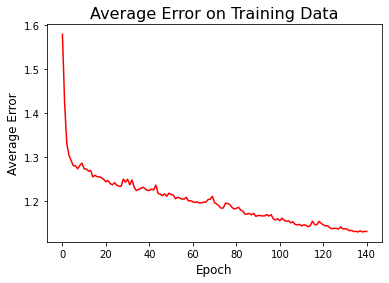

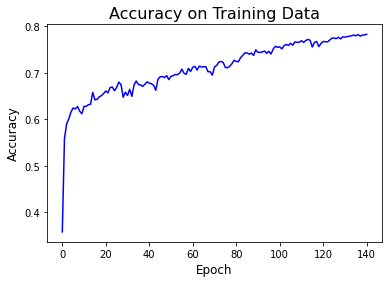

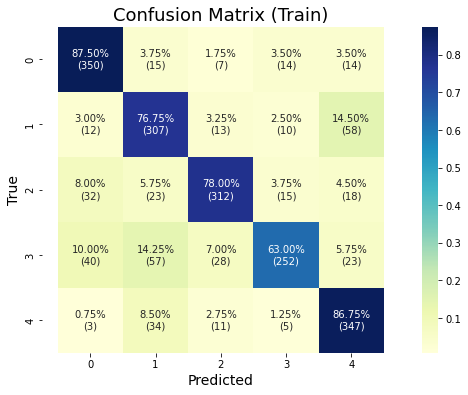

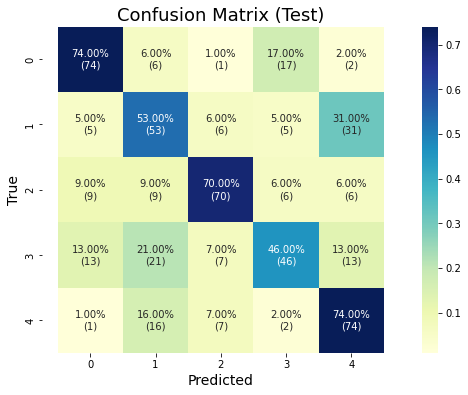

In [261]:
seed_all()
# No Normalization
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size, batch_norm=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam
classifier = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold, batch_size=batch_size)
classifier.optimizer_name = "No  Normalization"
# train_errors, train_accuracies = classifier.train(train_data, train_labels)
# loss, accuracy, predictions = classifier.evaluate(test_data, test_labels)
# print(f"Delta Rule: Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
# classifier.plot_avg_train_error(train_errors)
# classifier.plot_avg_train_accuracy(train_accuracies)
# cm_train = classifier.confusion_matrix_train(train_data, train_labels)
# cm_test = classifier.confusion_matrix_test(test_data, test_labels)
classifier.plot_all(train_data, train_labels, test_data, test_labels)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training:   8%|▊         | 775/10000 [00:37<07:24, 20.74epoch/s]


Converged at epoch 775
Pre-Activation Normalization Train: Loss: 0.9435617923736572, Accuracy: 0.9605, Epochs: 776
Pre-Activation Normalization Test: Loss: 1.2988260984420776, Accuracy: 0.592


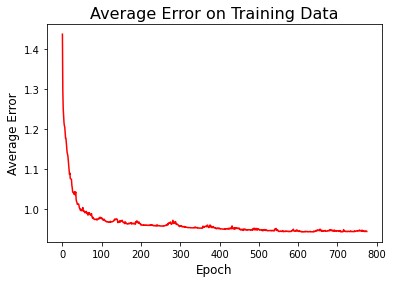

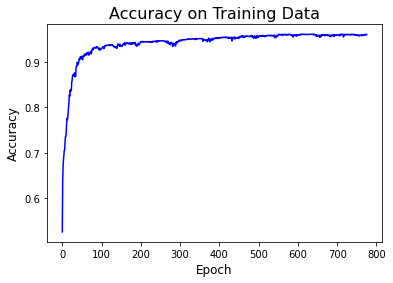

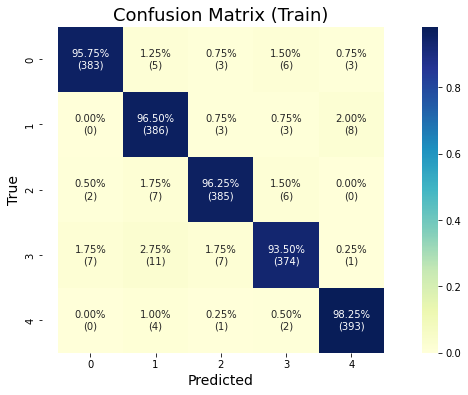

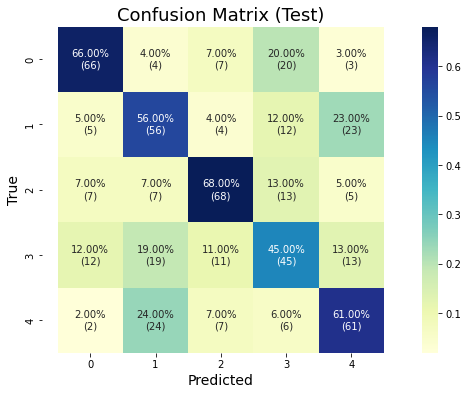

In [262]:
seed_all()
# Batch Normalization with pre-activation normalization
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size, batch_norm="pre")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam
classifier = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold, batch_size=batch_size)
classifier.optimizer_name = "Pre-Activation Normalization"
# train_errors, train_accuracies = classifier.train(train_data, train_labels)
# loss, accuracy, predictions = classifier.evaluate(test_data, test_labels)
# print(f"Delta Rule: Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
# classifier.plot_avg_train_error(train_errors)
# classifier.plot_avg_train_accuracy(train_accuracies)
# cm_train = classifier.confusion_matrix_train(train_data, train_labels)
# cm_test = classifier.confusion_matrix_test(test_data, test_labels)
classifier.plot_all(train_data, train_labels, test_data, test_labels)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training:   9%|▉         | 902/10000 [01:26<14:34, 10.40epoch/s]


Converged at epoch 902
Post-Activation Normalization Train: Loss: 0.9678260684013367, Accuracy: 0.937, Epochs: 903
Post-Activation Normalization Test: Loss: 1.2674360275268555, Accuracy: 0.634


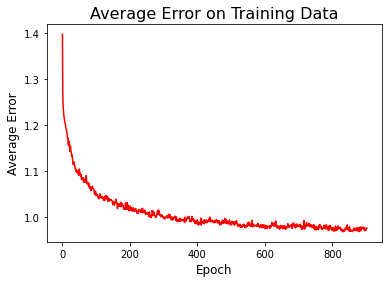

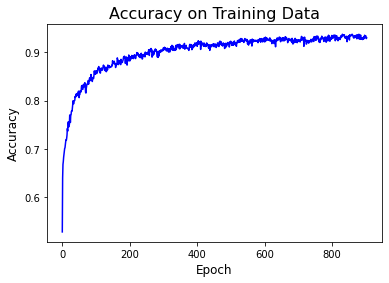

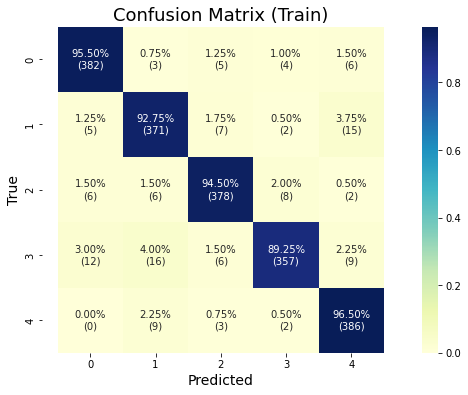

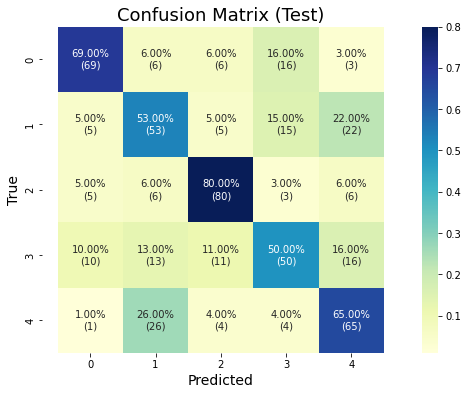

In [263]:
seed_all()
# Batch Normalization with post-activation normalization
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size, batch_norm="post")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam
classifier = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold, batch_size=batch_size)
classifier.optimizer_name = "Post-Activation Normalization"
# train_errors, train_accuracies = classifier.train(train_data, train_labels)
# loss, accuracy, predictions = classifier.evaluate(test_data, test_labels)
# print(f"Delta Rule: Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
# classifier.plot_avg_train_error(train_errors)
# classifier.plot_avg_train_accuracy(train_accuracies)
# cm_train = classifier.confusion_matrix_train(train_data, train_labels)
# cm_test = classifier.confusion_matrix_test(test_data, test_labels)
classifier.plot_all(train_data, train_labels, test_data, test_labels)